In [3]:
import pandas as pd

In [4]:
df_diabetes_cleaned = pd.read_csv("/Users/manuelrodriguezsutil/Developer/health-risk/data/diabetes_cleaned.csv")

In [5]:
df_diabetes_cleaned.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.751302,72.602865,28.972656,133.50651,32.409896,0.471876,33.240885,0.348958
std,3.369578,30.309174,11.704860,8.330715,67.87159,6.760263,0.331329,11.760232,0.476951
min,0.000000,56.000000,40.000000,7.000000,15.00000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,25.000000,122.00000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,122.00000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,122.00000,36.525000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,60.000000,495.00000,59.400000,2.420000,81.000000,1.000000


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
diabetes_features = ["Pregnancies",
                     "Glucose",
                     "BloodPressure",
                     "SkinThickness",
                     "Insulin",
                     "BMI",
                     "DiabetesPedigreeFunction",
                     "Age"]

In [9]:
X = df_diabetes_cleaned[diabetes_features]

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X = X_scaled
y = df_diabetes_cleaned['Outcome']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [13]:
rf = RandomForestClassifier(random_state=42)

In [14]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [16]:
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

RF Accuracy: 0.7727272727272727
RF AUC: 0.8189814814814814
Confusion Matrix:
 [[87 13]
 [22 32]]


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

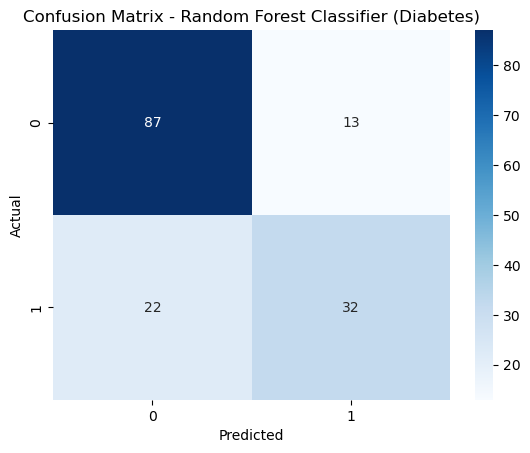

In [18]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest Classifier (Diabetes)")
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/diabetes/confusion_matrix_rf.png", dpi=300)
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

In [21]:
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [22]:
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

In [23]:
print("Best Params:", grid_search.best_params_)

Best Params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}


In [24]:
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

In [25]:
print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned RF AUC:", roc_auc_score(y_test, y_proba_best))

Tuned RF Accuracy: 0.7272727272727273
Tuned RF AUC: 0.8062962962962963


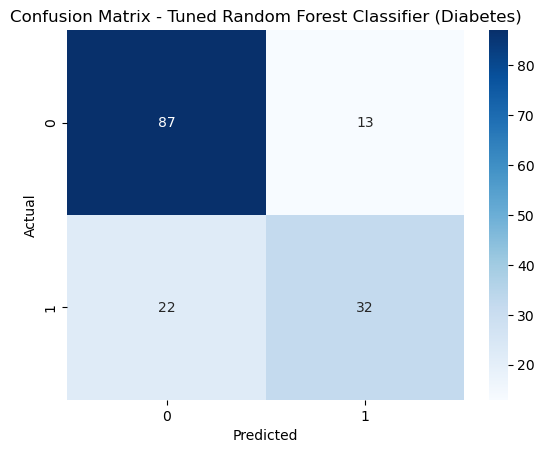

In [26]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Random Forest Classifier (Diabetes)")
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/diabetes/tuned_confusion_matrix_rf.png", dpi=300)
plt.show()

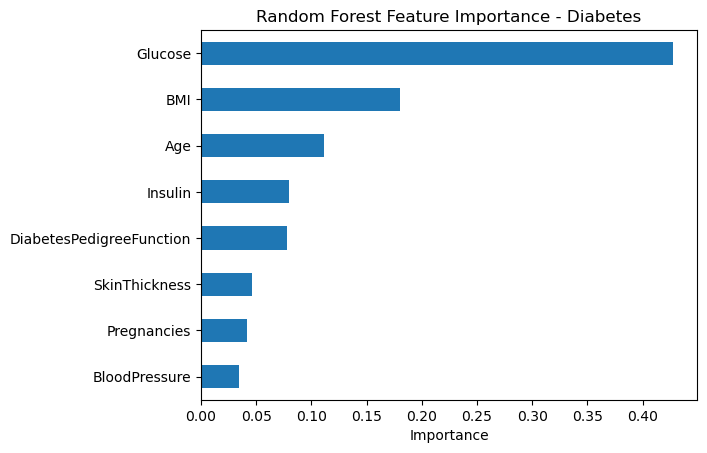

In [27]:
importances = pd.Series(best_rf.feature_importances_, index=diabetes_features)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Random Forest Feature Importance - Diabetes")
plt.xlabel("Importance")
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/diabetes/rf_importance.png")
plt.show()

In [28]:
import shap

In [29]:
X_test_df = pd.DataFrame(X_test, columns=diabetes_features)

In [30]:
explainer = shap.Explainer(best_rf, X_test_df)

In [31]:
shap_values = explainer(X_test_df, check_additivity=False)

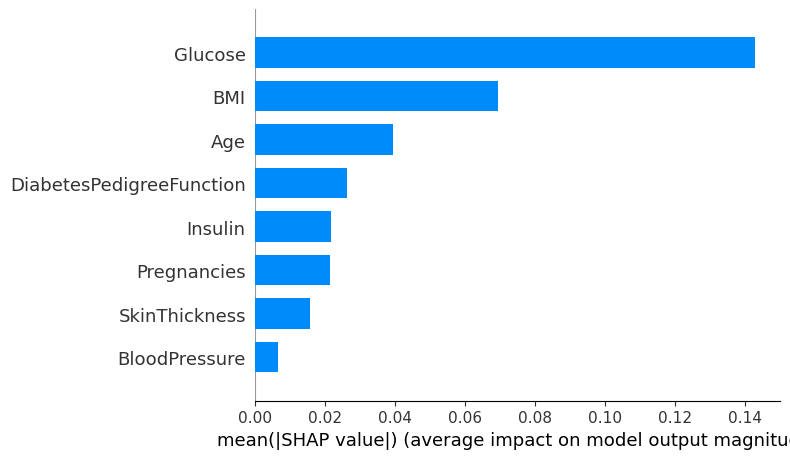

In [32]:
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values.values[:, :, 1], X_test_df, plot_type="bar")
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/diabetes/shap_summary_bar.png", dpi=300)
plt.close()

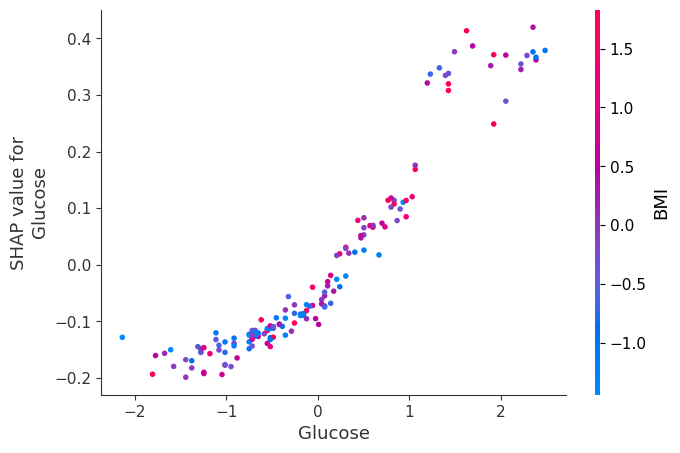

In [33]:
shap.dependence_plot("Glucose", shap_values.values[:, :, 1], X_test_df)
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/diabetes/shap_dependence_glucose.png", dpi=300)
plt.close()

In [34]:
shap.initjs

<function shap.plots._force.initjs()>

In [35]:
shap_values = explainer(X_test_df, check_additivity=False)

In [36]:
shap.plots.force(explainer.expected_value[0], shap_values.values[0])

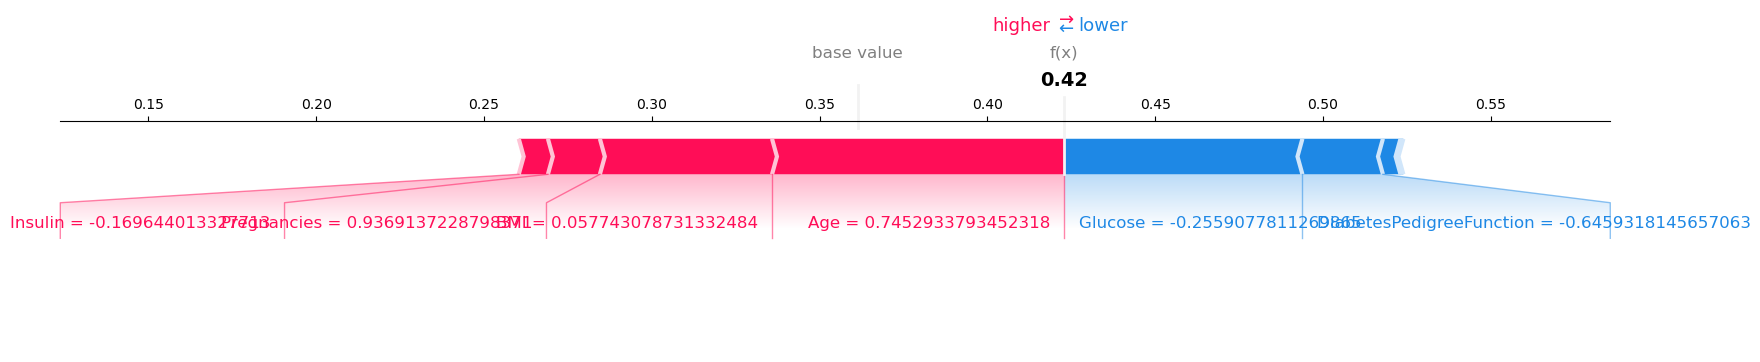

In [37]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values.values[28, :, 1],
    X_test_df.iloc[28],
    matplotlib=True
)

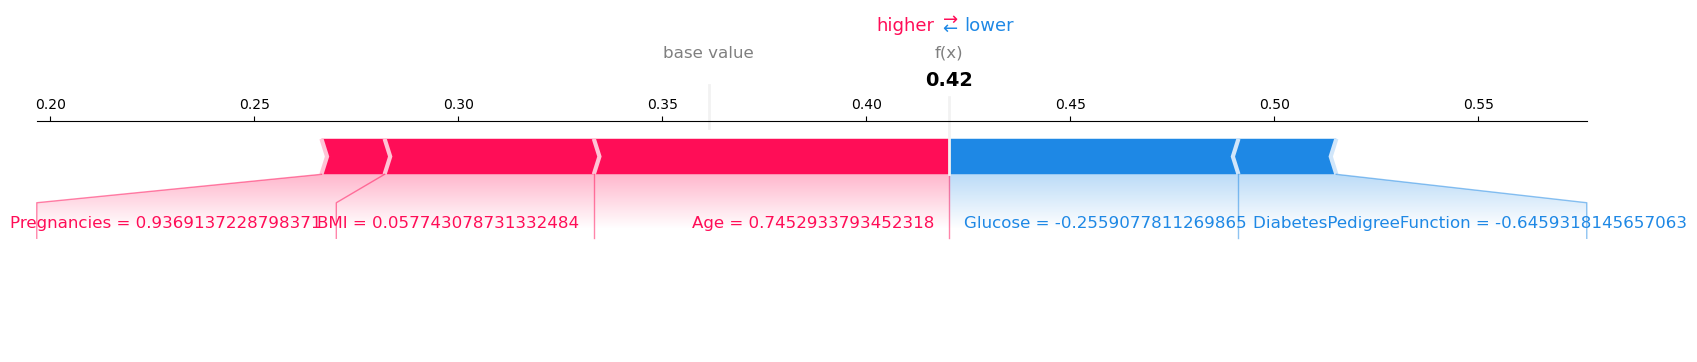

In [38]:
import numpy as np

shap_vals = shap_values.values[28, :, 1].copy()
top_n = 5
top_indices = np.argsort(np.abs(shap_vals))[-top_n:]
filtered_shap_vals = np.zeros_like(shap_vals)
filtered_shap_vals[top_indices] = shap_vals[top_indices]

shap.force_plot(
    explainer.expected_value[1],
    filtered_shap_vals,
    X_test_df.iloc[28],
    matplotlib=True
)

In [39]:
X_test_df.iloc[28][["Pregnancies", "BMI", "Age", "Glucose", "DiabetesPedigreeFunction"]]

Pregnancies                 0.936914
BMI                         0.057743
Age                         0.745293
Glucose                    -0.255908
DiabetesPedigreeFunction   -0.645932
Name: 28, dtype: float64

In [41]:
import joblib

In [45]:
joblib.dump(best_rf, "/Users/manuelrodriguezsutil/Developer/health-risk/models/diabetes_rf.pkl")
joblib.dump(scaler, "/Users/manuelrodriguezsutil/Developer/health-risk/models/diabetes_scaler.pkl")

['/Users/manuelrodriguezsutil/Developer/health-risk/models/diabetes_scaler.pkl']